# Business requirements
https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/overview  
Predict the department-wide sales for each store

# **Data Preparation**

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' %x)

In [3]:
features = pd.read_csv('https://raw.githubusercontent.com/passat05/Retail-data-analysis/272b60543e7f4a5197a0f463cf7076917df69293/Features%20data%20set.csv')
stores = pd.read_csv('https://raw.githubusercontent.com/passat05/Retail-data-analysis/272b60543e7f4a5197a0f463cf7076917df69293/stores%20data-set.csv')
sales = pd.read_csv('https://raw.githubusercontent.com/passat05/Retail-data-analysis/272b60543e7f4a5197a0f463cf7076917df69293/sales%20data-set.csv')
for table, name in zip([features, stores, sales],['features','stores','sales']):
    print(f'Table {name} has {table.shape[0]} row and {table.shape[1]} col')

Table features has 8190 row and 12 col
Table stores has 45 row and 3 col
Table sales has 421570 row and 5 col


In [4]:
stores.describe(percentiles=[.25, .5, .75, .9, .95, .995], include='all')

,Store,Type,Size
count,45.00,45,45.00
unique,NaN,3,NaN
top,NaN,A,NaN
freq,NaN,22,NaN
mean,23.00,NaN,130287.60
std,13.13,NaN,63825.27
min,1.00,NaN,34875.00
25%,12.00,NaN,70713.00
50%,23.00,NaN,126512.00
75%,34.00,NaN,202307.00


In [5]:
sales.describe(percentiles=[.25, .5, .75, .9, .95, .995], include='all')

,Store,Dept,Date,Weekly_Sales,IsHoliday
count,421570.00,421570.00,421570,421570.00,421570
unique,NaN,NaN,143,NaN,2
top,NaN,NaN,23/12/2011,NaN,False
freq,NaN,NaN,3027,NaN,391909
mean,22.20,44.26,NaN,15981.26,NaN
std,12.79,30.49,NaN,22711.18,NaN
min,1.00,1.00,NaN,-4988.94,NaN
25%,11.00,18.00,NaN,2079.65,NaN
50%,22.00,37.00,NaN,7612.03,NaN
75%,33.00,74.00,NaN,20205.85,NaN


In [6]:
print("In table Sales, num of negative of week_sales is {n} ({p}%)".format(n = len(sales.query('Weekly_Sales<= 0')), p = round(len(sales[sales['Weekly_Sales'] <= 0])/sales.shape[0]*100,2)))

In table Sales, num of negative of week_sales is 1358 (0.32%)


For these negative values, we will replace it with value 0

In [7]:
sales['Weekly_Sales'] = np.where(sales['Weekly_Sales'] < 0, 0, sales['Weekly_Sales'])

In [8]:
def outlier(df, col):
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  print(f'{col} has bound ({lower_bound};{upper_bound})')

In [9]:
outlier(sales, 'Weekly_Sales')

Weekly_Sales has bound (-25109.653749999998;47395.15625)


Although upper bound is at 47.4k, sales in retail chain has a little of outliers due to some occasional events in year, thus all values will be remained and explore further later

In [10]:
features.describe(percentiles=[.25, .5, .75, .9, .95, .995], include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,90%,95%,99.5%,max
Store,8190.00,NaN,NaN,NaN,23.00,12.99,1.00,12.00,23.00,34.00,41.00,43.00,45.00,45.00
Date,8190,182,05/02/2010,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Temperature,8190.00,NaN,NaN,NaN,59.36,18.68,-7.29,45.90,60.71,73.88,83.36,87.13,95.36,101.95
Fuel_Price,8190.00,NaN,NaN,NaN,3.41,0.43,2.47,3.04,3.51,3.74,3.90,4.02,4.28,4.47
MarkDown1,4032.00,NaN,NaN,NaN,7032.37,9262.75,-2781.45,1577.53,4743.58,8923.31,14767.59,21500.93,65628.44,103184.98
MarkDown2,2921.00,NaN,NaN,NaN,3384.18,8793.58,-265.76,68.88,364.57,2153.35,8546.67,17261.44,53545.44,104519.54
MarkDown3,3613.00,NaN,NaN,NaN,1760.10,11276.46,-179.26,6.60,36.26,163.15,530.47,1159.76,89366.82,149483.31
MarkDown4,3464.00,NaN,NaN,NaN,3292.94,6792.33,0.22,304.69,1176.42,3310.01,7570.29,12863.77,48136.80,67474.85
MarkDown5,4050.00,NaN,NaN,NaN,4132.22,13086.69,-185.17,1440.83,2727.14,4832.56,7625.70,10227.86,31378.82,771448.10
CPI,7605.00,NaN,NaN,NaN,172.46,39.74,126.06,132.36,182.76,213.93,221.46,223.87,228.04,228.98


Markdown seem to miss many values. However since Nov 2011, it was already run, so we will summary statistics of missing values later.

In [11]:
MarkDown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i in MarkDown:
    outlier(features, i)

MarkDown1 has bound (-9441.13375;19941.97625)
MarkDown2 has bound (-3057.825;5280.055)
MarkDown3 has bound (-228.22500000000002;397.975)
MarkDown4 has bound (-4203.2925000000005;7817.987500000001)
MarkDown5 has bound (-3646.7637500000005;9920.146250000002)


Although Markdowns in Features table are out of upper bound, they should be remained to reflect the state of promotional activies and serve the analysis later

In [12]:
summary = pd.merge(sales, features.loc[:, features. columns != 'IsHoliday'],how = 'left', on = ['Store','Date'])

In [13]:
summary = pd.merge(summary, stores, how = 'left', on = ['Store'])
summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


New table **summary** is created by merging from 3 above tables to serve EDA phase later.  
It reflects weekly sales by departments under many aspects

In [14]:
summary['Date'] = pd.to_datetime(summary['Date'], format='%d/%m/%Y')
summary['WeekOfYear'] = summary.Date.dt.isocalendar().week
summary['Year'] = summary.Date.dt.year

In [15]:
summary['Store'] = summary['Store'].astype('object')
summary['Dept'] = summary['Dept'].astype('object')

In [16]:
MarkDown = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i in MarkDown:
  rows = features[summary[i].isnull()].query(f"Date <= '2021-11-01'").shape[0]
  print(f"{i} has {rows} rows na in the dataset.")

MarkDown1 has 3506 rows na in the dataset.
MarkDown2 has 3842 rows na in the dataset.
MarkDown3 has 3539 rows na in the dataset.
MarkDown4 has 3506 rows na in the dataset.
MarkDown5 has 3506 rows na in the dataset.


For these nan values in Markdown, they shall be filled into 0 because they are expressed as no markdown applied

In [17]:
summary.fillna(0, inplace=True)

In [18]:
summary.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
WeekOfYear      0
Year            0
dtype: int64

In [19]:
cols = features.columns.to_list() + ['Size','Type','WeekOfYear','Year']
agg = summary.groupby(cols, dropna=False)['Weekly_Sales'].sum().sort_values(ascending=False).reset_index()

In [20]:
agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Temperature   6435 non-null   float64       
 3   Fuel_Price    6435 non-null   float64       
 4   MarkDown1     6435 non-null   float64       
 5   MarkDown2     6435 non-null   float64       
 6   MarkDown3     6435 non-null   float64       
 7   MarkDown4     6435 non-null   float64       
 8   MarkDown5     6435 non-null   float64       
 9   CPI           6435 non-null   float64       
 10  Unemployment  6435 non-null   float64       
 11  IsHoliday     6435 non-null   bool          
 12  Size          6435 non-null   int64         
 13  Type          6435 non-null   object        
 14  WeekOfYear    6435 non-null   UInt32        
 15  Year          6435 non-null   int32   

In [21]:
agg['Store'] = agg['Store'].astype('object')

Table **agg** is created to reflect weekly sales by stores under many aspects

# **EDA Categorical**

As see, they are 4 categorical variables including Store, Dept, Type vs IsHoliday.  

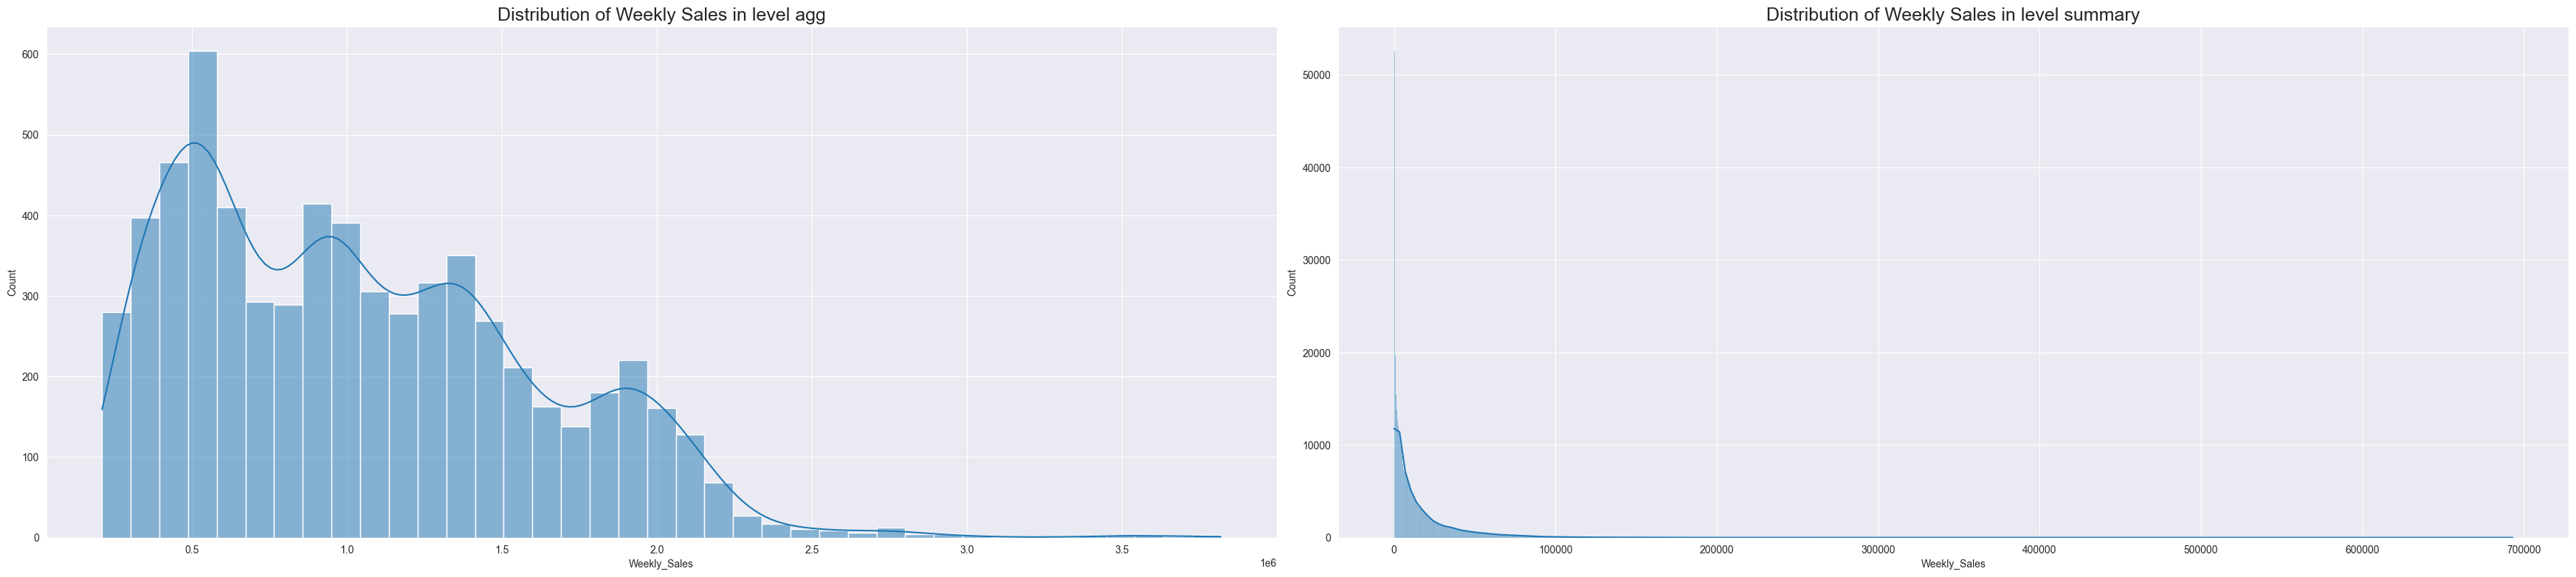

In [22]:
plt.figure(figsize=(35,15), facecolor='white')
plotnumber = 1
sns.set_style('darkgrid')
for i,u in zip([agg,summary],['agg','summary']):
    ax = plt.subplot(2,2,plotnumber)
    sns.histplot(data= i, x= 'Weekly_Sales', kde = True, palette="tab10")
    plt.title(f"Distribution of Weekly Sales in level {u}",fontsize = 18)
    plotnumber +=1
    
plt.tight_layout()    
plt.show()

We wil graph the median values of target variables "Weekly_Sales" on different categories due to the skewed distribution of sales

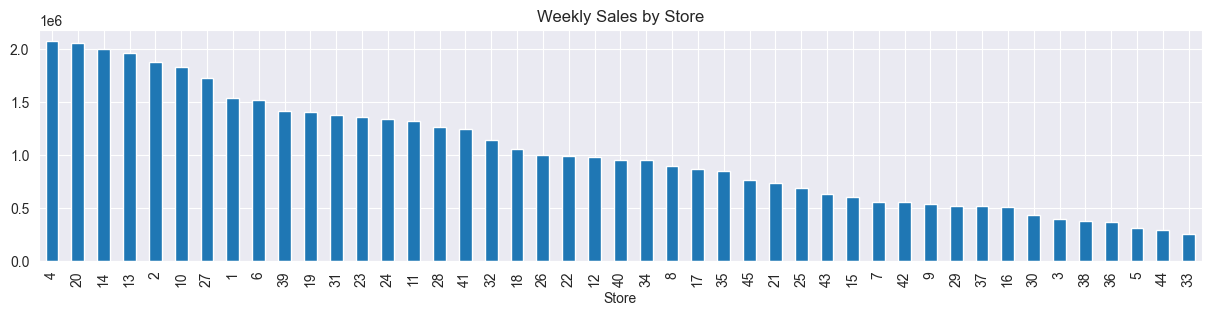

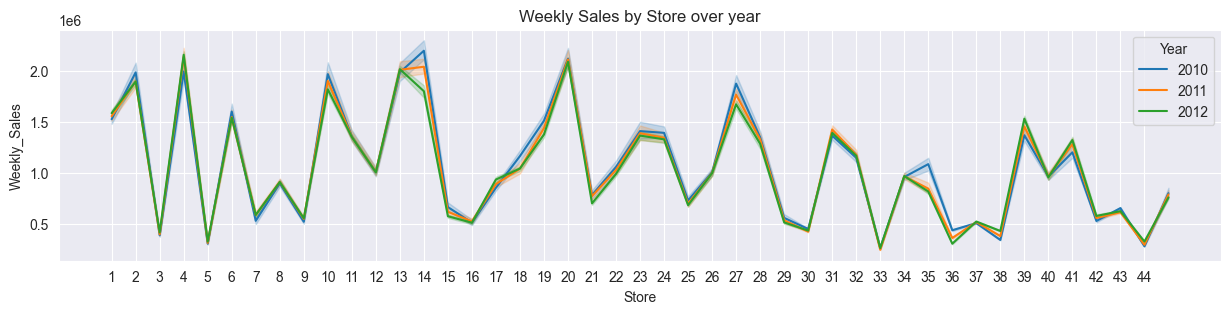

In [23]:
agg.groupby('Store').Weekly_Sales.median().sort_values(ascending=False).plot.bar(figsize=(15, 3),title='Weekly Sales by Store')
plt.figure(figsize=(15,3))
sns.lineplot(data= agg, x='Store', y='Weekly_Sales', hue='Year', palette= 'tab10')
plt.title('Weekly Sales by Store over year')
plt.xticks(range(1, 45))
plt.show()

There are differences between stores in term of weekly sales. This also remains over years.  
Top 10 having highest average sales are 4,20,14,13,2,10,27,1,6 and 39

In [24]:
print('Average Weekly Sales per Store is around {0}'.format(agg.Weekly_Sales.mean()))

Average Weekly Sales per Store is around 1046978.5778818959


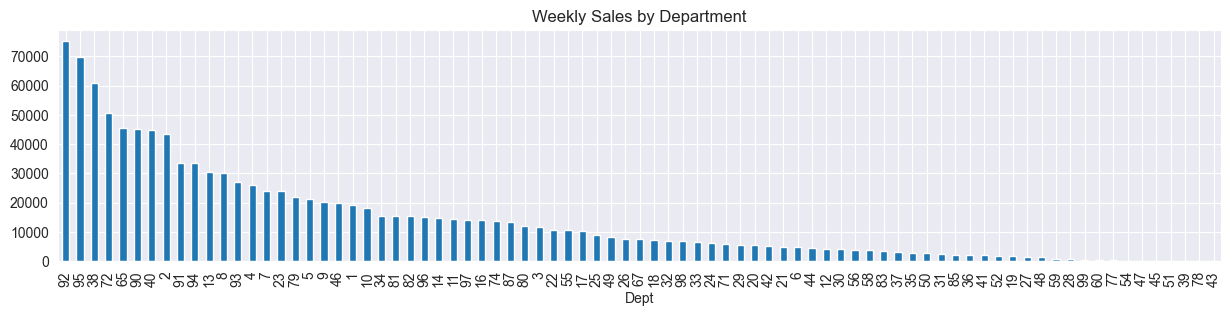

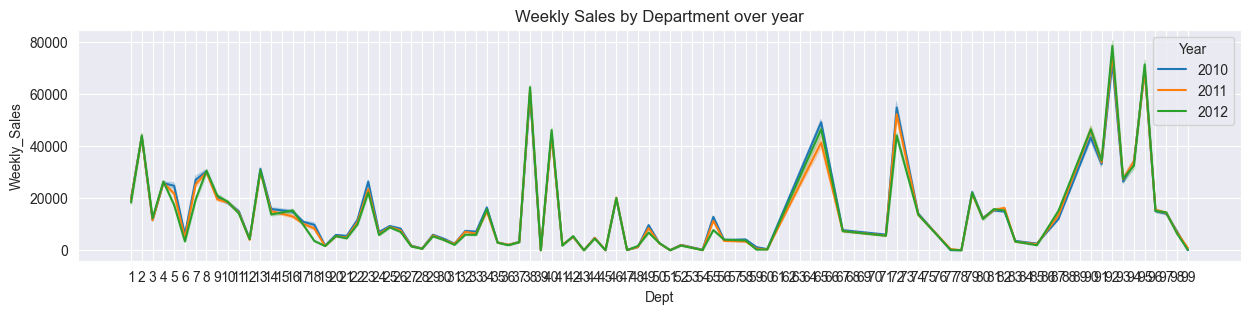

<Figure size 640x480 with 0 Axes>

In [25]:
summary.groupby('Dept').Weekly_Sales.mean().sort_values(ascending=False).plot.bar(figsize=(15, 3),title='Weekly Sales by Department')
plt.figure(figsize=(15,3))
sns.lineplot(data= summary, x='Dept', y='Weekly_Sales', hue='Year', palette= 'tab10')
plt.title('Weekly Sales by Department over year')
plt.xticks(range(1, 100))
plt.show()
plt.tight_layout()

There are differences between departments in term of weekly sales. This also remains over years.  
Top 10 having highest average sales are 92,95,38,65,72,40,2,90,94 and 91

In [26]:
print('Average Weekly Sales per department is around {0}'.format(summary.Weekly_Sales.mean()))

Average Weekly Sales per department is around 15981.467250207554


IsHoliday
True    7947.74
False   7589.95
Name: Weekly_Sales, dtype: float64


<Axes: xlabel='IsHoliday', ylabel='Weekly_Sales'>

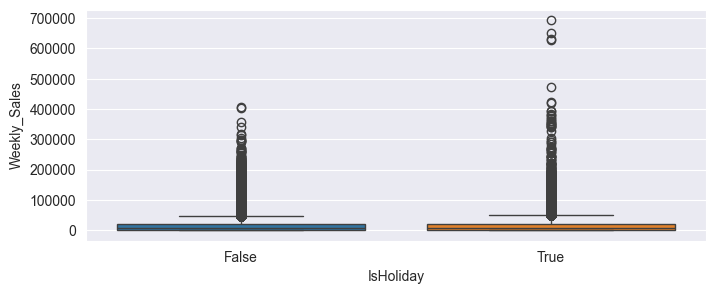

In [27]:
print(summary.groupby('IsHoliday').Weekly_Sales.median().sort_values(ascending=False))
plt.figure(figsize=(8,3))
sns.boxplot(data= summary, x='IsHoliday', y= 'Weekly_Sales', palette="tab10", dodge=False)

On the average, weekly sales in the holidays week are a bit higher than in the non-holiday weeks.  
Thus, in order that we can look at clearly about impact of holiday on sales, we need to visualize weekly_sales by time and map the specific occasional events.

In [28]:
summary.query('IsHoliday == True')['Date'].dt.strftime("%d-%m").unique()

array(['12-02', '10-09', '26-11', '31-12', '11-02', '09-09', '25-11',
       '30-12', '10-02', '07-09'], dtype=object)

In [29]:
holiday = {
    '10-02': 'Super Bowl',
    '11-02': 'Super Bowl',
    '12-02': 'Super Bowl',
    # '13-02': 'Official Super Bowl'
    # '04-09': 'Official Labor Day',
    '07-09': 'Labor Day',
    '09-09': 'Labor Day',
    '10-09': 'Labor Day',
    # '23-11': 'Thanksgiving',
    '25-11': 'Thanksgiving',
    '26-11': 'Thanksgiving',
    # '24-12': 'Official Christmas',
    '30-12': 'Christmas',
    '31-12': 'Christmas'
}

In [30]:
summary['Occasion'] = summary['Date'].dt.strftime("%d-%m").map(holiday)

In [31]:
summary['Occasion'].fillna('Normal', inplace = True)

In [32]:
summary['Occasion'].unique()

array(['Normal', 'Super Bowl', 'Labor Day', 'Thanksgiving', 'Christmas'],
      dtype=object)

Occasion
Thanksgiving   10007.38
Super Bowl      7969.23
Normal          7589.95
Labor Day       7502.66
Christmas       7046.26
Name: Weekly_Sales, dtype: float64


<Axes: xlabel='Occasion', ylabel='Weekly_Sales'>

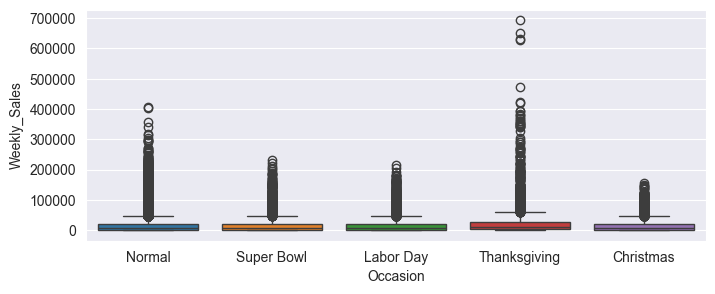

In [33]:
print(summary.groupby('Occasion').Weekly_Sales.median().sort_values(ascending=False))
plt.figure(figsize=(8,3))
sns.boxplot(data= summary, x='Occasion', y= 'Weekly_Sales', palette="tab10", dodge=False)

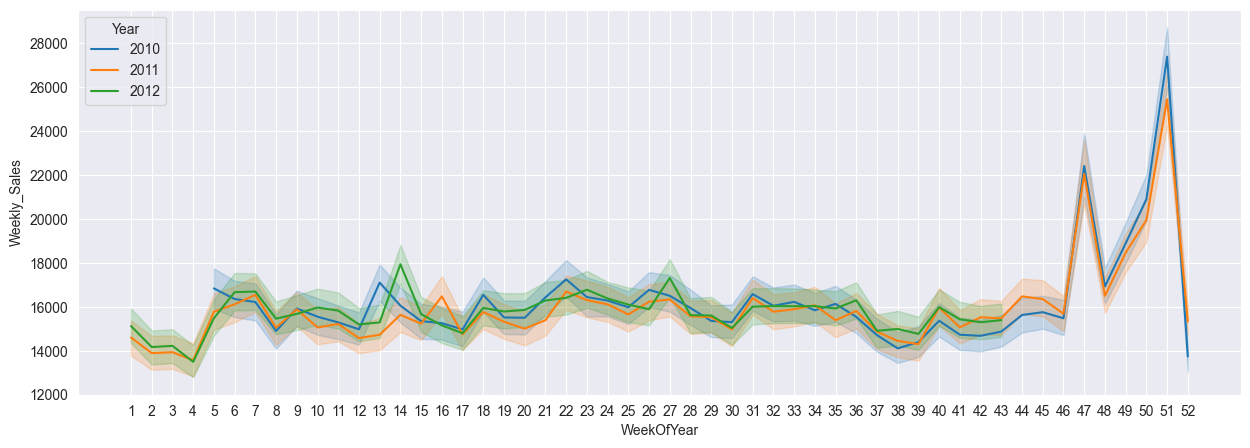

In [34]:
plt.figure(figsize=(15, 5))
sns.lineplot(data= summary, x='WeekOfYear', y='Weekly_Sales', hue='Year', palette= 'tab10')
plt.xticks(range(1, 53))
plt.show()

As seen, the highest spike weeks are 51, 47 respectively Christmas, Thanksgiving, followed by 36, 6 (Labor Day, Super Bowl).  
Together with holidays mentioned, Presidents' Day(Feb), Easter Day(Apr) shall be considerable.  
Additionally, combined with mapping holiday before, Christmas are mapped unproperly. 
Thus suggest re-map as follows:  
 - Week 51: Christmax  
 - Week 50: Before Christmas 1W  
 - Week 7: Presidents' Day  
 - Week 13(2010), Week 14(2012), Week 16(2011): Easter Day

In [35]:
occasion_adjusted = {
    '10-02': 'Super Bowl',
    '11-02': 'Super Bowl',
    '12-02': 'Super Bowl',
    # '13-02': 'Official Super Bowl'
    # '04-09': 'Official Labor Day',
    '07-09': 'Labor Day',
    '09-09': 'Labor Day',
    '10-09': 'Labor Day',
    '17-02': "Presidents' Day",
    '18-02': "Presidents' Day",
    '19-02': "Presidents' Day",
    '02-04': "Easter Day",
    '01-04': "Easter Day",
    '30-03': "Easter Day",
    '25-11': 'Thanksgiving',
    '26-11': 'Thanksgiving',
    '16-12': 'Before Christmas 1W',
    '17-12': 'Before Christmas 1W',
    '23-12': 'Christmas',
    '24-12': 'Christmas'
}

In [36]:
summary['Occasion_Adjusted'] = summary['Date'].dt.strftime("%d-%m").map(occasion_adjusted)
summary['Occasion_Adjusted'].fillna('Normal', inplace = True)

,count,mean,std,min,25%,50%,75%,max
Occasion_Adjusted,,,,,,,,
Before Christmas 1W,5972.00,20413.27,28057.07,0.00,2769.97,10271.83,26455.15,268789.69
Christmas,5983.00,26396.68,37786.84,0.00,3382.99,13355.14,34147.19,406988.63
Easter Day,8861.00,15704.45,21547.52,0.00,2182.21,7657.01,19939.93,203457.42
Labor Day,8861.00,15881.91,22618.80,0.00,1920.79,7502.66,19898.93,214448.96
Normal,368110.00,15626.55,21795.43,0.00,2046.86,7482.32,19840.33,293966.05
Presidents' Day,8929.00,16484.65,22780.51,0.00,2189.75,8262.04,20895.68,207773.40
Super Bowl,8895.00,16378.17,23399.03,0.00,2070.73,7969.23,20516.61,233140.32
Thanksgiving,5959.00,22221.02,41243.06,0.00,2592.62,10007.38,25892.79,693099.36


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

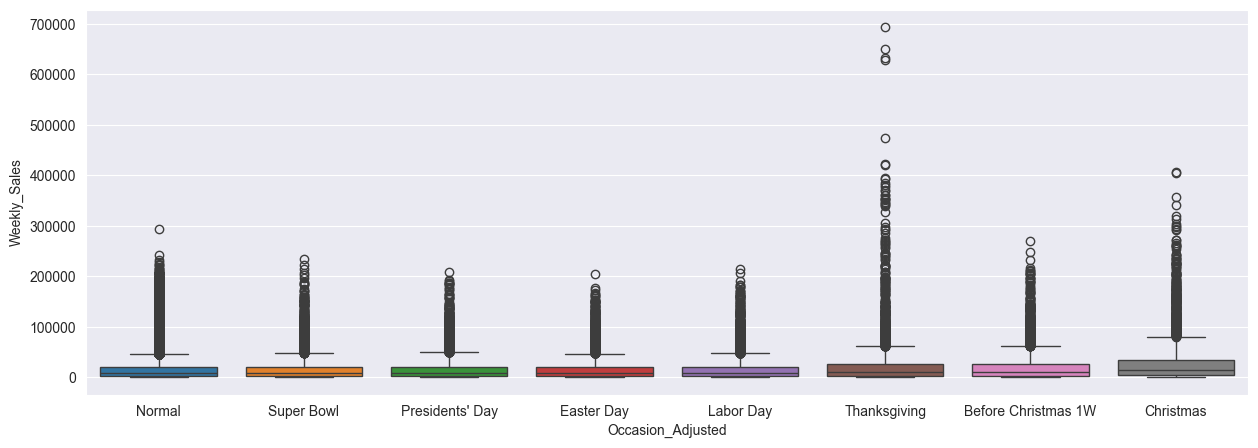

In [37]:
display(summary.groupby('Occasion_Adjusted')['Weekly_Sales'].describe())
plt.figure(figsize=(15,5))
sns.boxplot(data= summary, x='Occasion_Adjusted', y= 'Weekly_Sales', palette="tab10", dodge=False)
plt.xlabel

To sum up, there are 6 occasional events to be considerable to run campaigns which have driven up sales significantly

In [38]:
print(f'-Weekly Sales by Type in store level-')
display(agg.groupby('Type')['Weekly_Sales'].describe())
print(f'-Weekly Sales by Type in department level-')
display(summary.groupby('Type')['Weekly_Sales'].describe())

-Weekly Sales by Type in store level-


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,3146.00,1376687.06,530882.79,209986.25,1049999.68,1370656.48,1759442.43,3818686.45
B,2431.00,823011.78,407999.94,260636.71,537102.39,733037.32,996783.38,3749057.69
C,858.00,472620.07,115620.95,241937.11,377889.14,477821.59,556387.91,725043.04


-Weekly Sales by Type in department level-


,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,215478.00,20099.77,26423.30,0.00,3315.09,10105.17,26357.18,474330.10
B,163495.00,12237.33,17203.49,0.00,1927.05,6187.87,15353.74,693099.36
C,42597.00,9519.64,15985.29,0.00,131.99,1149.67,12695.01,112152.35


On average sales in both store and department level, Type A are much higher than other 2 types.

# **EDA: Continuous**

Correlation Metrics (Vans 1996):  
- 0-0.19 “very weak”  
- 0.20-0.39 “weak”  
- 0.40-0.59 “moderate”  
- 0.60-0.79 “strong”  
- 0.80-1.0 “very strong”  

<Axes: >

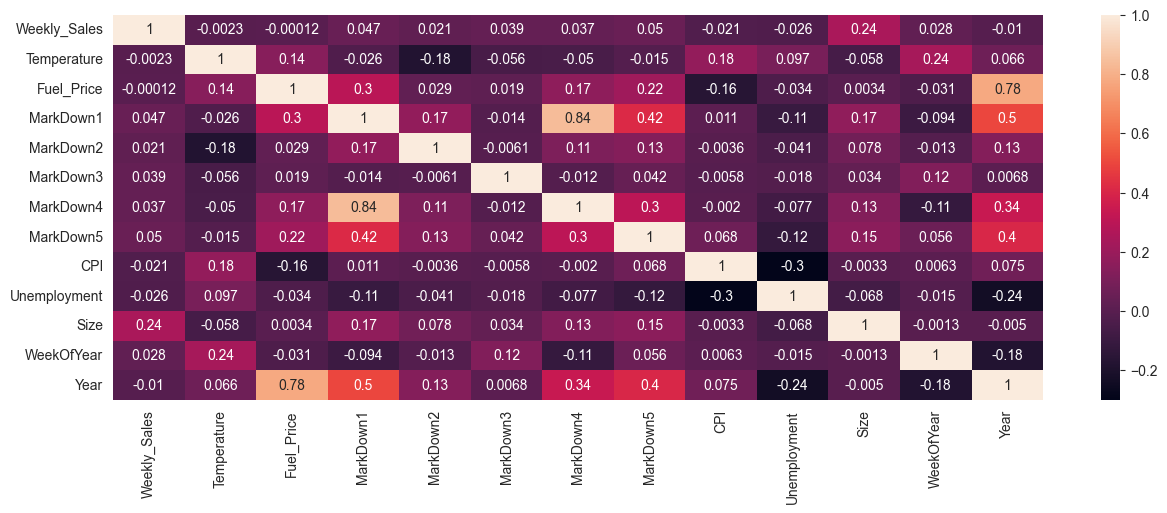

In [39]:
plt.figure(figsize=(15,5))
sns.heatmap(summary.select_dtypes(include='number').corr(), annot = True)

In department-wide, most of attributes have very weak correlation with 'Weekly_Sales'.  
However we can check further whether the impact of each Markdown to every department is or not in the later part

<Axes: >

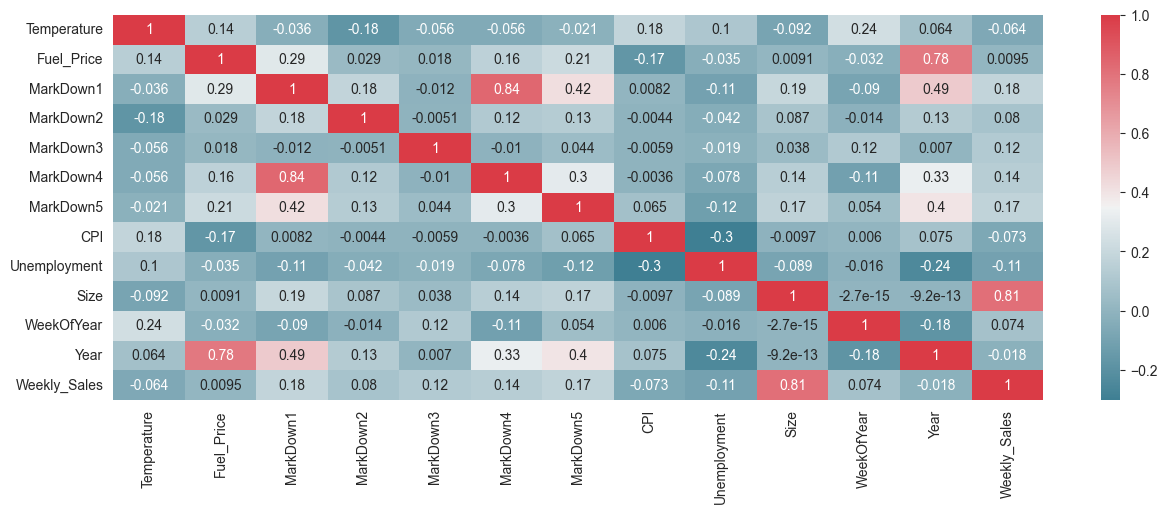

In [40]:
plt.figure(figsize=(15,5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(agg.select_dtypes(include='number').corr(), cmap=cmap, annot = True)

In store-wide, most of attributes are very weak correlated to 'Weekly_Sales' except Size, MarkDown 1 and MarkDown 5. In details:  
 - Size have a very strong with 'Weekly_Sales'
 - MarkDown are quite week but should be explored further to consider whether stores are impacted with MarkDowns

In [41]:
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

In [42]:
for i in range(45):
    for markdown in MarkDown:
        df = agg[(agg[markdown].notna())&(agg['Store']==i+1)&(agg['Date']>='2011-11-01')]
        if len(df) >= 2:
            corr, _ = pearsonr(df['Weekly_Sales'], df[markdown])
            if abs(corr) >= 0.6:
                print(f'Pearsons correlation between Store {i+1} and {markdown} ({len(df)}): %.2f' % corr)

Pearsons correlation between Store 5 and MarkDown3 (52): 0.65
Pearsons correlation between Store 35 and MarkDown3 (52): 0.71


Although Pearsons correlation seem to be quite high but the number of variables is quite low, so we conclude that no store has been impacted by MarkDown

In [43]:
dept = summary['Dept'].unique()
dept_list = set(dept)
for i in dept_list:
    for markdown in MarkDown:
        df = summary[(summary[markdown].notna())&(summary['Dept'] == i+1)&(summary['Date']>='2011-11-01')]
        if len(df) >= 2:
            corr, _ = pearsonr(df['Weekly_Sales'], df[markdown])
            if abs(corr) >= 0.6:
                print(f'Pearsons correlation between dept {i+1} and {markdown} ({len(df)} pairs): %.2f' % corr)

Pearsons correlation between dept 6 and MarkDown3 (2138 pairs): 0.61
Pearsons correlation between dept 72 and MarkDown3 (2207 pairs): 0.67


As seen, only department 72 and 6 has a strong correlation with 'Weekly_Sales'.

<Axes: xlabel='MarkDown3', ylabel='Weekly_Sales'>

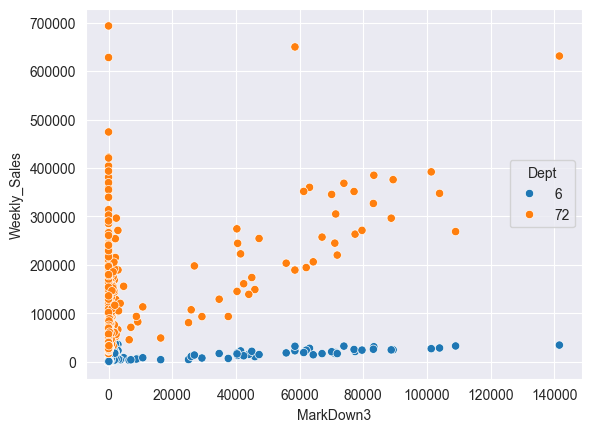

In [44]:
sns.scatterplot(data= summary[(summary['Dept'].isin([6,72]))], y= 'Weekly_Sales', x = 'MarkDown3', palette="tab10", hue = 'Dept')

**Train ML Model**

In [45]:
summary['IsHoliday'] = summary['IsHoliday'].replace(True, 1).replace(False, 0)

In [46]:
summary['Store'] = summary['Store'].astype('int')
summary['Dept'] = summary['Dept'].astype('int')

In [47]:
summary.columns = summary.columns.str.lower()

In [48]:
summary.sort_values(by=['date'], inplace=True)

In [49]:
numerics_cols = [i for i in summary.select_dtypes(include='number').columns.to_list() if i not in 'weekly_sales']
categorical_cols = ['type','occasion_adjusted']

In [50]:
one_hot_df = pd.get_dummies(summary[categorical_cols],prefix='_',prefix_sep='',dtype=float)
one_hot_cols = one_hot_df.columns
df = pd.merge(summary[numerics_cols + ['weekly_sales']], one_hot_df, left_index=True, right_index=True)

In [51]:
df.columns = df.columns.str.lower()

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 421570 entries, 0 to 421569
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   store                 421570 non-null  int32  
 1   dept                  421570 non-null  int32  
 2   isholiday             421570 non-null  int64  
 3   temperature           421570 non-null  float64
 4   fuel_price            421570 non-null  float64
 5   markdown1             421570 non-null  float64
 6   markdown2             421570 non-null  float64
 7   markdown3             421570 non-null  float64
 8   markdown4             421570 non-null  float64
 9   markdown5             421570 non-null  float64
 10  cpi                   421570 non-null  float64
 11  unemployment          421570 non-null  float64
 12  size                  421570 non-null  int64  
 13  weekofyear            421570 non-null  UInt32 
 14  year                  421570 non-null  int32  
 15  weekl

In [53]:
df_train = df[:int(.7*len(df))].reset_index(drop=True)
df_val = df[int(.7*len(df)):int(.85*len(df))].reset_index(drop=True)
df_test = df[int(.85*len(df)):].reset_index(drop=True)

In [54]:
len(df_train),len(df_val),len(df_test)

(295099, 63235, 63236)

In [55]:
y_train = np.log1p(df_train.weekly_sales)
y_val = np.log1p(df_val.weekly_sales)
y_test = np.log1p(df_test.weekly_sales)

In [56]:
del df_train['weekly_sales']
del df_val['weekly_sales']
del df_test['weekly_sales']

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
scaler = MinMaxScaler().fit(df_train[numerics_cols])
for x in [df_train,df_val,df_test]:
    x[numerics_cols] = scaler.transform(x[numerics_cols])

In [59]:
X_train = df_train
X_val = df_val
X_test = df_test

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
def evaluation_metrics(y_test,y_pred):
    mse = mean_squared_error(y_test,y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test,y_pred)
    r2score = r2_score(y_test,y_pred)
    
    print(f'Mean Squared Error = {mse}')
    print(f'Mean Absolute Error = {mae}')
    print(f'Root Mean Squared Error = {rmse}')
    print(f'r2 score = {r2score}')

In [62]:
rf = RandomForestRegressor(n_estimators=50, random_state=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=1)

In [63]:
y_pred = rf.predict(X_val)

In [64]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)
print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.6007761840700746
R2: 0.9157076046533115


In [65]:
for d in [10, 15, 20, 25, 30]:
    scores = []
    r2 = []
    for n in [10, 50, 100, 150, 200]:
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r = r2_score(y_val, y_pred)

        scores.append(rmse)
        r2.append(r)

    print((d,sum(scores) / len(scores),sum(r2) / len(r2)))

(10, 0.7945011731991529, 0.8525814476385593)
(15, 0.6162285523547263, 0.9112951155968823)
(20, 0.6019836269243737, 0.9153309289097719)
(25, 0.6057408995952314, 0.9142446544925633)
(30, 0.6060256151177376, 0.9141556037225922)


Random Forest with max_depth = 20 and n_estimators = 200 is the best model